##Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Installs

In [ ]:
!pip install giotto-tda

     |████████████████████████████████| 1.5MB 11.0MB/s 
     |████████████████████████████████| 28.5MB 100kB/s 
     |████████████████████████████████| 20.6MB 114kB/s 
     |████████████████████████████████| 22.3MB 132kB/s 
     |████████████████████████████████| 3.2MB 8.6MB/s 
     |████████████████████████████████| 409kB 25.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install ripser

     |████████████████████████████████| 71kB 5.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for ripser: filename=ripser-0.6.0-cp37-cp37m-linux_x86_64.whl size=454913 sha256=b6d7e198b1c88cc2606fe9cf322cd30519d3bbc78ddc594400fe0d75764fbe0e
  Stored in directory: /root/.cache/pip/wheels/95/1e/13/59da989de59903698d767dcb19414163e683a2dd31edf80417
Successfully built ripser
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=0076857e8052e72c02d9a9850c08358100e67a4e2302d82ba4f113252d30dbbe
  Stored in directory: /root/.cache/pip/wheels/2b/e1/c9/1993c7f7f114b7d3fb2d3e895e02157a7ebf554861e9e54e01
Successfully built hopcroftkarp


##Imports

In [ ]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
import requests #for downloading zip file
from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tabulate import tabulate # for verbose tables
from tensorflow.keras.utils import to_categorical # for one-hot encoding
from tensorflow import keras 
from tensorflow.keras import layers 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from gtda.time_series import TakensEmbedding
from ripser import Rips
from persim import plot_diagrams
from persim import PersImage
from persim import PersistenceImager
from sklearn.svm import SVC
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, concatenate
from tensorflow.keras.models import Model

##Helpful functions

In [ ]:
def create_confusion_matrix(trues, preds, name, title, num_classes):
    t_names = [i for i in range(num_classes)]
    cm = confusion_matrix(trues, preds)
    cm_df = pd.DataFrame(cm,
                       index = t_names, 
                       columns = t_names)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.savefig(f'{name}_confusion_matrix.pdf')
    plt.show()

##Takens embedding method

In [ ]:
def embed(x_train, x_test, num=3):
  #reshape train and test data for embedder if needed
  if len(x_train.shape) == 3:
    fixed_xtrain = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
    fixed_xtest = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

  embedder = TakensEmbedding(dimension=num, stride=1)

  emb_xtrain = embedder.fit_transform(fixed_xtrain)
  emb_xtest = embedder.transform(fixed_xtest)

  return emb_xtrain, emb_xtest

##Persistence image extractor

In [ ]:
def extract_pi(emb_xtrain, emb_xtest, fit=True, p_size=0.2):
  #perform rips filtration
  rips = Rips()
  xtrain_h1 = [rips.fit_transform(data)[1] for data in emb_xtrain]
  xtest_h1 = [rips.fit_transform(data)[1] for data in emb_xtest]

  #create persistence image
  pimgr = PersistenceImager(pixel_size=p_size)

  if fit:
    pimgr.fit(xtrain_h1)

  xtrain_imgs = pimgr.transform(xtrain_h1)
  xtest_imgs = pimgr.transform(xtest_h1)

  return np.array(xtrain_imgs), np.array(xtest_imgs)

##Create model

In [ ]:
def create_models(xtrain_imgs, emb_xtrain, y_train, k_size=10, tda_k_size=10):
  tda_input_shape = xtrain_imgs.shape[1:]
  baseline_input_shape = emb_xtrain.shape[1:]
  n_outputs = y_train.shape[1]

  #model inputs
  baseline_input = Input(shape=baseline_input_shape)
  tda_input = Input(shape=tda_input_shape)

  #create baseline architecture
  x = Conv1D(filters=100, kernel_size=k_size, activation='relu')(baseline_input)
  x = Conv1D(filters=100, kernel_size=k_size, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = MaxPooling1D(pool_size=2)(x)
  x = Flatten()(x)
  x = Dense(100, activation='relu')(x)
  baseline_concat = Model(inputs=baseline_input, outputs=x)

  #output layer for baseline model used to compare baseline and final performance
  baseline_out = Dense(n_outputs, activation='softmax')(x)
  baseline_estimator = Model(inputs = baseline_input, outputs = baseline_out)

  #create TDA CNN architecture
  y = Conv1D(filters=100, kernel_size=tda_k_size, activation='relu')(tda_input)
  y = Conv1D(filters=100, kernel_size=tda_k_size, activation='relu')(y)
  y = Dropout(0.5)(y)
  y = MaxPooling1D(pool_size=2)(y)
  y = Flatten()(y)
  y = Dense(100, activation='relu')(y)
  tda_concat = Model(inputs=tda_input, outputs=y)

  #combine models
  combined_layer = concatenate([baseline_concat.output, tda_concat.output])
  z = Dense(100, activation='relu')(combined_layer)
  z = Dense(n_outputs, activation='softmax')(z)

  model = Model(inputs=[baseline_concat.input, tda_concat.input], outputs = z)

  return baseline_estimator, model

##Method to run train/test pipeline

In [ ]:
def run_pipeline(x_train, x_test, y_train, y_test, eps=15, batch_sz=32, 
                 tda_eps=15, tda_batch_sz=32, k_size=10, tda_k_size=10):
  #embed data
  emb_xtrain, emb_xtest = embed(x_train, x_test)

  #extract persistence images
  xtrain_imgs, xtest_imgs = extract_pi(emb_xtrain, emb_xtest)

  #create models
  baseline_estimator, model = create_models(xtrain_imgs, emb_xtrain, y_train, 
                                            k_size, tda_k_size)

  #fit baseline
  baseline_estimator.compile(loss="categorical_crossentropy", 
                             optimizer="adam", metrics=["accuracy"])
  
  history = baseline_estimator.fit(emb_xtrain, y_train, epochs = eps,
                                 validation_data = (emb_xtest, y_test),
                                 batch_size=batch_sz,
                                 verbose=0)
  
  #fit final model
  model.compile(loss="categorical_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

  history = model.fit([emb_xtrain, xtrain_imgs], y_train, epochs = tda_eps,
                    validation_data = ([emb_xtest, xtest_imgs], y_test),
                    batch_size=tda_batch_sz, verbose=0)
  
  #gather model predictions
  baseline_probs = baseline_estimator.predict(emb_xtest)
  final_probs = model.predict([emb_xtest, xtest_imgs])

  #return baseline and final model's test predictions
  return np.argmax(baseline_probs, axis=1), np.argmax(final_probs, axis=1)

##Five fold CV of UniMiB

###Data loader

In [ ]:
#download zip from URL
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

In [ ]:
def unimib_load_dataset(verbose = False,
                        incl_xyz_accel = False, #include component accel_x/y/z in ____X data
                        incl_rms_accel = True, #add rms value (total accel) of accel_x/y/z in ____X data
                        incl_val_group = False, #True => returns x/y_test, x/y_validation, x/y_train
                           #False => combine test & validation groups
                        split_subj = dict
                        (train_subj = [4,5,6,7,8,10,11,12,14,15,19,20,21,22,24,26,27,29],
                         validation_subj = [1,9,16,23,25,28],
                         test_subj = [2,3,13,17,18,30]),
                        one_hot_encode = True):
    #Download and unzip original dataset
    if (not os.path.isfile('./UniMiB-SHAR.zip')):
        print("Downloading UniMiB-SHAR.zip file")
        #invoking the shell command fails when exported to .py file
        #redirect link https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        #!wget https://www.dropbox.com/s/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip
        download_url('https://www.dropbox.com/s/raw/x2fpfqj0bpf8ep6/UniMiB-SHAR.zip','./UniMiB-SHAR.zip')
    if (not os.path.isdir('./UniMiB-SHAR')):
        shutil.unpack_archive('./UniMiB-SHAR.zip','.','zip')
    #Convert .mat files to numpy ndarrays
    path_in = './UniMiB-SHAR/data'
    #loadmat loads matlab files as dictionary, keys: header, version, globals, data
    adl_data = io.loadmat(path_in + '/adl_data.mat')['adl_data']
    adl_names = io.loadmat(path_in + '/adl_names.mat', chars_as_strings=True)['adl_names']
    adl_labels = io.loadmat(path_in + '/adl_labels.mat')['adl_labels']

    if(verbose):
        headers = ("Raw data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    #Reshape data and compute total (rms) acceleration
    num_samples = 151 
    #UniMiB SHAR has fixed size of 453 which is 151 accelX, 151 accely, 151 accelz
    adl_data = np.reshape(adl_data,(-1,num_samples,3), order='F') #uses Fortran order
    if (incl_rms_accel):
        rms_accel = np.sqrt((adl_data[:,:,0]**2) + (adl_data[:,:,1]**2) + (adl_data[:,:,2]**2))
        adl_data = np.dstack((adl_data,rms_accel))
    #remove component accel if needed
    if (not incl_xyz_accel):
        adl_data = np.delete(adl_data, [0,1,2], 2)
    if(verbose):
        headers = ("Reshaped data","shape", "object type", "data type")
        mydata = [("adl_data:", adl_data.shape, type(adl_data), adl_data.dtype),
                ("adl_labels:", adl_labels.shape ,type(adl_labels), adl_labels.dtype),
                ("adl_names:", adl_names.shape, type(adl_names), adl_names.dtype)]
        print(tabulate(mydata, headers=headers))
    #Split train/test sets, combine or make separate validation set
    #ref for this numpy gymnastics - find index of matching subject to sub_train/sub_test/sub_validate
    #https://numpy.org/doc/stable/reference/generated/numpy.isin.html


    act_num = (adl_labels[:,0])-1 #matlab source was 1 indexed, change to 0 indexed
    sub_num = (adl_labels[:,1]) #subject numbers are in column 1 of labels

    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = adl_data[train_index]
        y_train = act_num[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['validation_subj']))
        x_validation = adl_data[validation_index]
        y_validation = act_num[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = adl_data[test_index]
    y_test = act_num[test_index]

    if (verbose):
        print("x/y_train shape ",x_train.shape,y_train.shape)
        if (incl_val_group):
            print("x/y_validation shape ",x_validation.shape,y_validation.shape)
        print("x/y_test shape  ",x_test.shape,y_test.shape)
    #If selected one-hot encode y_* using keras to_categorical, reference:
    #https://keras.io/api/utils/python_utils/#to_categorical-function and
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
    if (one_hot_encode):
        y_train = to_categorical(y_train, num_classes=9)
        if (incl_val_group):
            y_validation = to_categorical(y_validation, num_classes=9)
        y_test = to_categorical(y_test, num_classes=9)
        if (verbose):
            print("After one-hot encoding")
            print("x/y_train shape ",x_train.shape,y_train.shape)
            if (incl_val_group):
                print("x/y_validation shape ",x_validation.shape,y_validation.shape)
            print("x/y_test shape  ",x_test.shape,y_test.shape)
    if (incl_val_group):
        return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        return x_train, y_train, x_test, y_test  

###Run the cross validation

In [ ]:
y_trues = [] #to hold actual target vals across folds
final_preds = [] #to hold final model's predictions across folds
baseline_preds = [] #to hold baseline model's predictions

for i in range(0, 30, 6):
  #create fold
  test_subj = [x for x in range(i+1, i+7)]
  train_subj = [x for x in range(1, i+1)]
  val_subj = [x for x in range(i+7, 31)]

  #load data
  x_train, y_train, x_test, y_test = unimib_load_dataset(split_subj=dict(
      train_subj = train_subj,
      validation_subj = val_subj,
      test_subj = test_subj
  ))
  
  #save target labels for evaluation
  y_trues.extend(np.argmax(y_test, axis=1))

  #run experiment
  baseline_probs, ensemble_preds = run_pipeline(x_train, x_test, 
                                                y_train, y_test)
  
  #gather model predictions for evaluation
  baseline_preds.extend(baseline_probs)
  final_preds.extend(ensemble_preds)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


Classification report for baseline model
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       153
           1       0.53      0.37      0.44       216
           2       0.89      0.90      0.90      1738
           3       0.96      0.94      0.95      1985
           4       0.85      0.77      0.81       921
           5       0.90      0.95      0.93       746
           6       0.79      0.88      0.83      1324
           7       0.52      0.55      0.53       296
           8       0.64      0.58      0.61       200

    accuracy                           0.86      7579
   macro avg       0.76      0.73      0.74      7579
weighted avg       0.85      0.86      0.85      7579

Classification report for final model
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       153
           1       0.54      0.51      0.53       216
           2       0.93      0.89      0.91      1738

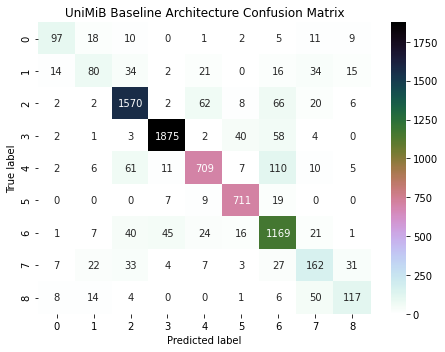


Confusion matrix for final model


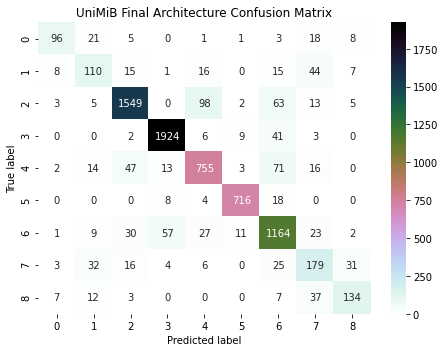

In [ ]:
#evaluate model
print('Classification report for baseline model')
print(classification_report(y_trues, baseline_preds))
print('Classification report for final model')
print(classification_report(y_trues, final_preds))

print('\nConfusion matrix for baseline model')
create_confusion_matrix(y_trues, baseline_preds, 'unimib_tda_baseline', 
                        'UniMiB Baseline Architecture', 9)
print('\nConfusion matrix for final model')
create_confusion_matrix(y_trues, final_preds, 'unimib_tda_final', 
                        'UniMiB Final Architecture', 9)

#gather predictions into a csv for easy access later
df = pd.DataFrame()
df['y_true'] = y_trues
df['baseline_preds'] = baseline_preds
df['final_preds'] = final_preds
df.to_csv('unimib_TDA_5cv.csv')

#CV of MobiAct data

##More imports

In [ ]:
import glob # to generate lists of files in directory - unix style pathnames

##Data loader

In [ ]:
def get_mobiact_fname_mdata(path_in):
    """returns dataframe with filename and metadata from mobiact directory
    args: path_in is location of files e.g. JOG, JUM, etc directories
    returns: pandas dataframe with one row for each file.
    columns are full filename, activity, subject, group {unassigned, train, validate, test}"""
    df = pd.DataFrame() # new empty dataframe
    GRP = ['train','validation','test']
    ACT = ['JOG','JUM','STD','STN','STU','WAL']
    for i in ACT:    
        sub_path = path_in + i + '/'
        fname_in = i + '_acc_*.txt'
        print("Generating filenames ", fname_in," from ", sub_path," directory")
        # Build list of matching files in each directory, make into dataframe
        # extract and add metadata
        in_files = glob.glob(os.path.join(sub_path, fname_in)) # generates a list of all matching files
        temp = pd.DataFrame(in_files,dtype="string") # easier in pandas, make column of filenames
        temp.columns = ['fname'] # name the column
        temp['ACT'] = i # add column with activity
        temp['SUB'] = temp['fname'].str.extract(r'(\d+)') # uses pd method and regex get SUB from fname
        # both columns are type object, would be better to set but didn't work first time
        df = pd.concat([df,temp], ignore_index=True ) # concat needs two df, add regardless of index   
    # add column for validation, test groups by subject, others are marked train
    df["SUB"] = pd.to_numeric(df["SUB"]) #convert from object to INT32
    return df

In [ ]:
def assign_group(df,split_subj):
    """returns dataframe with filename and metadata from mobiact directory
    args: dataframe with mobiact fname, ACT, SUB columns
    returns: dataframe with GRP = {train, test, validate} column added
    GRP assignment is based on list in split_subj
    """
    df['GRP'] = 'unassigned' # add column
    df.loc[df['SUB'].isin(split_subj['train_subj']),'GRP'] = 'train'
    df.loc[df['SUB'].isin(split_subj['validation_subj']),'GRP'] = 'validation'
    df.loc[df['SUB'].isin(split_subj['test_subj']),'GRP'] = 'test'
    return df

In [ ]:
def read_mobiact_file(full_filename):
    """returns dataframe from Mobiact txt file accel_xyz data, skips metadata, labels columns"""
    df = pd.read_csv(full_filename,skiprows=16, header=None) #skip 16 lines of metadata
    # json better? https://docs.python.org/3/library/json.html#module-json initial tries weren't successful
    df.columns = ["nanoseconds", "accel_x", "accel_y", "accel_z"]
    return df

In [ ]:
def add_total_accel(df_in, delete_xyz=False):
    """computes rms of accel_x/y/z data, removed 1g component, adds accel_total column"""
    # compute rms accel and remove 1g due to gravity, removes rotational dependency
    dfx = df_in.pow(2)[['accel_x','accel_y','accel_z']] #square each accel
    df_sum = dfx.sum(axis=1) #add sum of squares, new 1 col df
    df_in.loc[:,'accel_total'] = df_sum.pow(0.5)-9.8  # sqrt + remove 1g gravity component
    del dfx, df_sum
    if delete_xyz:
        return df_in.drop(columns = ['accel_x','accel_y','accel_z'])
    else: 
        return df_in

In [ ]:
def to_abs_time(df):
    """subtracts the value of 1st nanosecond sample from all samples"""
    start_time = df.loc[0,'nanoseconds']
    df.loc[:,'nanoseconds'] = df.loc[:,'nanoseconds'] - start_time
    return df

In [ ]:
def get_df_from_file(fname, start_discard=100, end_discard=100):
    """processes mobiact file fname and returns dataframe of accel values
    inputs: fname = full filemane
            start_discard = number of initial samples to delete (default = 200)
            end_discard = number of final samples to delete (default = 200)
    output: pandas dataframe of shape (samples, accel_total)"""
    df = read_mobiact_file(fname)
    df = add_total_accel(df,delete_xyz=True)
    df = df.drop(columns=['nanoseconds']) # note this loses some time info - datetime better?
    df.drop(df.head(start_discard).index,inplace=True) # drop first rows
    df.drop(df.tail(end_discard).index,inplace=True) # drop last rows
    return df

In [ ]:
def split_df_npX(df, num_samples = 500):
    """converts dataframe (samples, total_accel) into 3D numpy array of shape
    (num_segments, num_samples, total_accel). e.g. a 1800 row dataframe will
    result in a (3,500,1) numpy array.   The samples that don't populate an
    entire segment are discarded and there is no overlap (sliding window)
    input:  dataframe with one files worth of data, index=samples, column=total_accel
            num_samples = number samples (rows) in each segment, default = 500
    ouput:  numpy array in trainX format shape = (segments, samples/segment, 1)"""
    temp = df.to_numpy() # easier to reshape and final form needed anyway
    if (temp.shape[0]//num_samples)==0:
        print ("WARNING:  File contains less than ",num_samples,"samples and is discarded")
    temp2 = temp[0:num_samples*(temp.shape[0]//num_samples)] # truncate to multiple of num_samples
    tempX = temp2.reshape(-1,num_samples,1) # won't work with out truncation
    return tempX

In [ ]:
def mobiact_adl_load_dataset(
    verbose = False,
    #Pass location of the original MobiAct zip file here.
    #Easiest way to find this in colab is:
    #  -mount your google drive with MobiAct zip file (link is above)
    #  -navigate to the file using File menu to left
    #  -right click on file and select 'copy path', paste in next line
    orig_zipfile = '/content/drive/MyDrive/datasets/MobiAct_Dataset_v1.0.zip',
    incl_xyz_accel = False, #include component accel_x/y/z in ____X data
    incl_rms_accel = True, #add rms value of accel_x/y/z in ____X data
    incl_val_group = False, #True => returns x/y_test, x/y_validation, x/y_train
                           #False => combine test & validation groups
    split_subj = {'train_subj':[2,4,5,9,10,16,18,20,23,24,26,27,28,32,34,35,
                                36,38,42,45,46,47,48,49,50,51,52,53,54,57],
                   'validation_subj':[3,6,8,11,12,22,37,40,43,56],
                   'test_subj':[7,19,21,25,29,33,39,41,44,55]},
    one_hot_encode = True
    ):
    #unzip original dataset from google drive map into colab session
    if (not os.path.isdir('/content/MobiAct_Dataset')):
        print("Unzipping MobiAct Dataset")
        shutil.unpack_archive(orig_zipfile,'/content','zip')
    else:
        print("Using existing archive in colab")
    df_flist = get_mobiact_fname_mdata('/content/MobiAct_Dataset/')
    df_flist = assign_group(df_flist,split_subj)
    #Note:  STU, STN files don't contain 900 samples so 200 discard start/finish + 500 time step doesn't work
    # Create zero'd np arrays otherwise accumulates when run more than once
    # should be a better way to do this
    trainX = np.zeros(shape=(1,500,1)) #otherwise accumulates when run more than once
    trainy = np.zeros(shape=(1,6))
    validationX = np.zeros(shape=(1,500,1))
    validationy = np.zeros(shape=(1,6))
    testX = np.zeros(shape=(1,500,1))
    testy = np.zeros(shape=(1,6))
    for i in df_flist.index:
        if ((df_flist['GRP'][i])=='train'):
            #print ("processing train file", df_flist['fname'][i])
            df = get_df_from_file(df_flist['fname'][i])
            tempX = split_df_npX(df)
            trainX = np.vstack([trainX, tempX])
            tempy = np.zeros(shape=(tempX.shape[0],6)) # 6 is number of ACT
            #one hot encoding of ACT
            #Class indices are  {'JOG': 0, 'JUM': 1, 'STD': 2, 'STN': 3, 'STU': 4, 'WAL': 5}
            #to match the ones generated by Keras image import
            if ((df_flist['ACT'][i])=='JOG'): tempy[:,0]=1
            if ((df_flist['ACT'][i])=='JUM'): tempy[:,1]=1
            if ((df_flist['ACT'][i])=='STD'): tempy[:,2]=1
            if ((df_flist['ACT'][i])=='STN'): tempy[:,3]=1
            if ((df_flist['ACT'][i])=='STU'): tempy[:,4]=1
            if ((df_flist['ACT'][i])=='WAL'): tempy[:,5]=1
            trainy = np.vstack([trainy, tempy])
        if ((df_flist['GRP'][i])=='validation'):
            #print ("processing test file", df_flist['fname'][i])
            df = get_df_from_file(df_flist['fname'][i])
            tempX = split_df_npX(df)
            validationX = np.vstack([validationX, tempX])
            tempy = np.zeros(shape=(tempX.shape[0],6)) # 6 is number of ACT
            #one hot encoding of ACT
            if ((df_flist['ACT'][i])=='JOG'): tempy[:,0]=1
            if ((df_flist['ACT'][i])=='JUM'): tempy[:,1]=1
            if ((df_flist['ACT'][i])=='STD'): tempy[:,2]=1
            if ((df_flist['ACT'][i])=='STN'): tempy[:,3]=1
            if ((df_flist['ACT'][i])=='STU'): tempy[:,4]=1
            if ((df_flist['ACT'][i])=='WAL'): tempy[:,5]=1
            validationy = np.vstack([validationy, tempy])
        if ((df_flist['GRP'][i])=='test'):
            #print ("processing test file", df_flist['fname'][i])
            df = get_df_from_file(df_flist['fname'][i])
            tempX = split_df_npX(df)
            testX = np.vstack([testX, tempX])
            tempy = np.zeros(shape=(tempX.shape[0],6)) # 6 is number of ACT
            #one hot encoding of ACT
            if ((df_flist['ACT'][i])=='JOG'): tempy[:,0]=1
            if ((df_flist['ACT'][i])=='JUM'): tempy[:,1]=1
            if ((df_flist['ACT'][i])=='STD'): tempy[:,2]=1
            if ((df_flist['ACT'][i])=='STN'): tempy[:,3]=1
            if ((df_flist['ACT'][i])=='STU'): tempy[:,4]=1
            if ((df_flist['ACT'][i])=='WAL'): tempy[:,5]=1
            testy = np.vstack([testy, tempy])
    #delete first row placeholders
    trainX = np.delete(trainX, (0), axis=0) 
    trainy = np.delete(trainy, (0), axis=0)
    validationX = np.delete(validationX, (0), axis=0) 
    validationy = np.delete(validationy, (0), axis=0)
    testX = np.delete(testX, (0), axis=0)
    testy = np.delete(testy, (0), axis=0)
    if (incl_val_group):
        return trainX, trainy, validationX, validationy, testX, testy
    else:
        return np.concatenate((trainX, validationX), axis=0),\
            np.concatenate((trainy, validationy), axis=0),\
            testX, testy

##Run the five-fold cross validation

In [ ]:
y_trues = [] #to hold actual target vals across folds
final_preds = [] #to hold final model's predictions across folds
baseline_preds = [] #to hold baseline model's predictions

for i in range(1, 55, 11):
  #create fold
  test_subj = [x for x in range(i+1, i+12)]
  train_subj = [x for x in range(2, i+1)]
  val_subj = [x for x in range(i+7, 56)]

  #make sure to not go over bounds (since 11 doesn't divide 54)
  if 56 in test_subj:
    test_subj.remove(56)

  #load data
  x_train, y_train, x_test, y_test = mobiact_adl_load_dataset(split_subj=dict(
      train_subj = train_subj,
      validation_subj = val_subj,
      test_subj = test_subj
  ))
  
  #save target labels for evaluation
  y_trues.extend(np.argmax(y_test, axis=1))

  #run experiment
  baseline_probs, ensemble_preds = run_pipeline(x_train, x_test, 
                                                y_train, y_test, eps=15, 
                                                tda_eps=15, k_size=50, 
                                                tda_k_size=5)
  
  #gather model predictions for evaluation
  baseline_preds.extend(baseline_probs)
  final_preds.extend(ensemble_preds)

Using existing archive in colab
Generating filenames  JOG_acc_*.txt  from  /content/MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  /content/MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  /content/MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  /content/MobiAct_Dataset/STN/  directory
Generating filenames  STU_acc_*.txt  from  /content/MobiAct_Dataset/STU/  directory
Generating filenames  WAL_acc_*.txt  from  /content/MobiAct_Dataset/WAL/  directory
Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Using existing archive in colab
Generating filenames  JOG_acc_*.txt  from  /content/MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  /content/MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  /content/MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  /content/MobiAct_Dataset/STN/  directory
Generating f

Classification report for baseline model
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       697
           1       0.83      0.75      0.79       677
           2       0.90      0.98      0.94      2086
           3       0.50      0.26      0.34       287
           4       0.59      0.67      0.63       286
           5       0.99      0.93      0.96      2675

    accuracy                           0.89      6708
   macro avg       0.77      0.76      0.76      6708
weighted avg       0.89      0.89      0.89      6708

Classification report for final model
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       697
           1       0.96      0.96      0.96       677
           2       1.00      1.00      1.00      2086
           3       0.81      0.80      0.81       287
           4       0.77      0.89      0.82       286
           5       0.99      0.98      0.98      2675

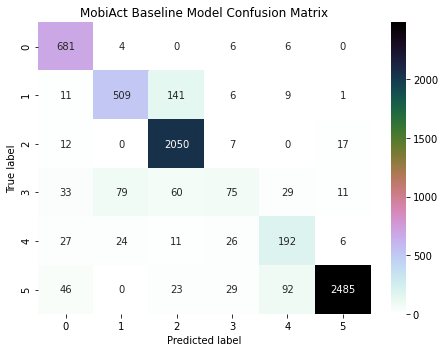


Confusion matrix for final model


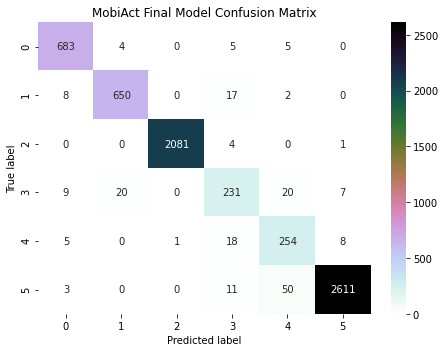

In [ ]:
#evaluate model
print('Classification report for baseline model')
print(classification_report(y_trues, baseline_preds))
print('Classification report for final model')
print(classification_report(y_trues, final_preds))

print('\nConfusion matrix for baseline model')
create_confusion_matrix(y_trues, baseline_preds, 'mobiact_baseline', 
                        'MobiAct Baseline Model', max(y_trues)+1)
print('\nConfusion matrix for final model')
create_confusion_matrix(y_trues, final_preds, 'mobiact_tda', 
                        'MobiAct Final Model', max(y_trues)+1)

#gather predictions into a csv for easy access later
df = pd.DataFrame()
df['y_true'] = y_trues
df['baseline_preds'] = baseline_preds
df['final_preds'] = final_preds
df.to_csv('mobiAct_TDA_5cv.csv')

#CV of UCI HAR data

##Data loader

#CV of EEG data

##Installs

In [ ]:
!pip install mne

     |████████████████████████████████| 7.0MB 32.7MB/s 


##More imports

In [ ]:
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import tensorflow.keras as keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, Cropping2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Reshape
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

##Data loader

In [ ]:
#Get epochs with sliding window 
def getEpochs(subjects, runs, event_id):
    # set your path to save the dataset
    dataset_path = './EEGBCI_dataset'
    tmin, tmax = -1., 4. 
    subject_row = []

    for subject in subjects:
        raw_fnames = eegbci.load_data(subject, runs, dataset_path)
        #concatenate multiply runs into one instance
        subject_row.append(concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]))
    raw = concatenate_raws([row for row in subject_row])

    eegbci.standardize(raw)
    # set channel names standard_1005
    montage = make_standard_montage('standard_1005') # Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
    raw.set_montage(montage)

    #Strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    #Apply band-pass filter 
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')  # band pass filter 
    
    #Get events from raw signal 
    events, _ = events_from_annotations(raw, event_id=event_id)

    #Choose only EEG signals 
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

    #Get epochs from raw data  
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

    epochs_data = epochs.get_data()
    labels = epochs.events[:, -1] - 1
        
    return epochs_data, labels

##Create baseline EEG model

In [ ]:
def EEG_ConvNet(nb_classes, Chans = 64, Samples = 160, dropoutRate = 0.5):

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(30, (1, 8),   # Convolution along time with filters of size [1 x 8]
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(30, (Chans, 1), use_bias=False, # Convolution accross channels with filters of size [#channels x 1]
                          kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    # We use the The exponential linear unit (ELU) activation function 
    block1       = Activation('elu')(block1) 
    block1       = MaxPooling2D(pool_size=(1, 8), strides=(1, 3))(block1)
    block1       = Activation('elu')(block1)
    block1       = Dropout(dropoutRate)(block1)
    
    block2       = Conv2D(50, (1, 3),   # Convolution along time with filters of size [1 x 3]
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 4), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    flatten      = Flatten()(block2)
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

###Add functions for training and prediction

In [ ]:
def train(X_train, Y_train, X_val, Y_val, model, batch_size = 128, 
          epochs = 100, filename = 'results'):
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filename+"Rand42.h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
    ]
    
    
    fittedModel = model.fit(X_train, Y_train, batch_size = batch_size, 
                            epochs = epochs, validation_split=0.2, verbose = 0,
                            validation_data=(X_val, Y_val), 
                            callbacks = callbacks)
    return fittedModel

In [ ]:
def test(model, X_test, Y_test, filename):
    model.load_weights(filename+'Rand42.h5')
    probs = model.predict(X_test)
    preds = probs.argmax(axis = 1)  
    acc = np.mean(preds == Y_test)
    
    return acc, probs

##Fetch data

In [ ]:
def load_epochs(test_subj, train_subj, val_subj):
  final_train = train_subj
  final_train.extend(val_subj) #we no longer need a validation group

  task3_runs = [5, 9, 13]
  task3_event_id = dict(T1=1, T2=2)

  train_epochs, train_labels = getEpochs(final_train, task3_runs, 
                                         task3_event_id)
  
  test_epochs, test_labels = getEpochs(test_subj, task3_runs, 
                                         task3_event_id)
  
  return (train_epochs, train_labels), (test_epochs, test_labels)

##Run the five-fold CV

In [ ]:
#Control GPU memory growth
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True # Allow memory allocation to grow beyond the initial default size
session = InteractiveSession(config=config)
K.set_image_data_format('channels_first')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#generate subject slices
y_trues = [] #to hold actual target vals across folds
final_preds = [] #to hold final model's predictions across folds
baseline_preds = [] #to hold baseline model's predictions

#for reshaping data
chans = 64
samples = 801

for i in range(0, 20, 5):
  #create fold
  test_subj = [x for x in range(i+1, i+6)]
  train_subj = [x for x in range(1, i+1)]
  val_subj = [x for x in range(i+6, 21)]

  #get epochs and labels
  train_data, test_data = load_epochs(test_subj, train_subj, val_subj)

  #separate labels and data
  x_train, train_labels = train_data[0], train_data[1]
  x_test, test_labels = test_data[0], test_data[1]

  #convert labels to categorical
  y_train = to_categorical(train_labels)
  y_test = to_categorical(test_labels)

  #save y test
  y_trues.extend(test_labels)

  #get baseline model
  model = EEG_ConvNet(nb_classes = 2, Chans = 64, Samples = 800, 
                      dropoutRate = 0.5)

  #reshape input data
  x_train_reshape = x_train.reshape(x_train.shape[0], 1, chans, 
                                    samples).astype('float32') * 10000
  x_train_reshape = x_train_reshape[:,:,:,:-1]

  x_test_reshape = x_test.reshape(x_test.shape[0], 1, chans, 
                                  samples).astype('float32') * 10000
  x_test_baseline = x_test_reshape[:,:,:,:-1]

  #split training set into validation data
  x_train_baseline, x_val_baseline, y_train_baseline, y_val_baseline = train_test_split(x_train_reshape, y_train, test_size=0.2)

  #train baseline
  fittedmodel = train(x_train_baseline, np.argmax(y_train_baseline, axis=1), 
                      x_val_baseline, np.argmax(y_val_baseline, axis=1),
                      model, epochs = 100, filename = 'EEG_ConvNettask3')
  
  #gather baseline predictions
  _, train_probs = test(model, x_train_reshape, np.argmax(y_train,axis=1),
                        'EEG_ConvNettask3')
  _, test_probs = test(model, x_test_baseline, np.argmax(y_test,axis=1),
                       'EEG_ConvNettask3')
  
  #perform TDA
  xtrain_imgs, xtest_imgs = extract_pi(x_train, x_test, fit = False, p_size=0.02)

  #create persistence model
  img_model = create_persistence_model(xtrain_imgs, y_train)

  #train persistence model
  img_model.compile(loss="binary_crossentropy", optimizer="adam", 
              metrics=["accuracy"])

  img_model.fit(xtrain_imgs, y_train,
                steps_per_epoch = xtrain_imgs.shape[1]//32,
                epochs = 50,
                verbose = 0)
  
  #gather persistence model predictions
  train_img_probs = img_model.predict(xtrain_imgs)
  test_img_probs = img_model.predict(xtest_imgs)

  #create final model
  stacked_deep_train = np.hstack((train_probs, train_img_probs))
  stacked_deep_test = np.hstack((test_probs, test_img_probs))

  svc = SVC()
  svc.fit(stacked_deep_train, train_labels)

  svc_preds = svc.predict(stacked_deep_test)

  #save predictions across folds
  baseline_preds.extend(np.argmax(test_probs, axis=1))
  final_preds.extend(svc_preds)

Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs

/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud 

Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud 

Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud 

Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/EEGBCI_dataset/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs

/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud has more columns than rows; "
/usr/local/lib/python3.7/dist-packages/ripser/ripser.py:258: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  "The input point cloud 

Classification report for baseline model
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       445
           1       0.58      0.51      0.54       455

    accuracy                           0.56       900
   macro avg       0.56      0.56      0.56       900
weighted avg       0.56      0.56      0.56       900

Classification report for final model
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       445
           1       0.60      0.51      0.55       455

    accuracy                           0.58       900
   macro avg       0.58      0.58      0.58       900
weighted avg       0.58      0.58      0.58       900


Confusion matrix for baseline model


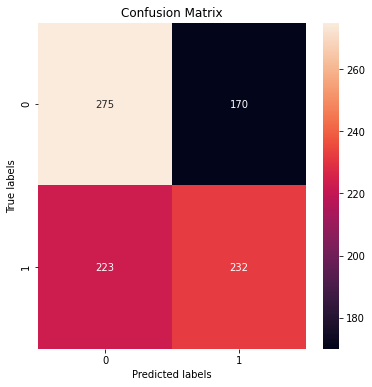


Confusion matrix for final model


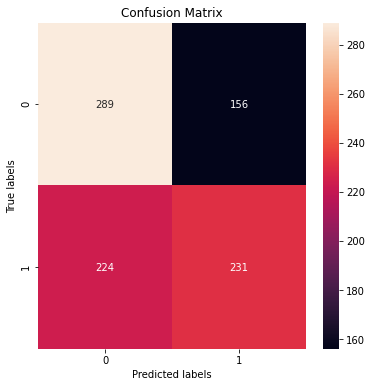

In [ ]:
#evaluate model
print('Classification report for baseline model')
print(classification_report(y_trues, baseline_preds))
print('Classification report for final model')
print(classification_report(y_trues, final_preds))

print('\nConfusion matrix for baseline model')
create_confusion_matrix(y_trues, baseline_preds, 2)
print('\nConfusion matrix for final model')
create_confusion_matrix(y_trues, final_preds, 2)

#gather predictions into a csv for easy access later
df = pd.DataFrame()
df['y_true'] = y_trues
df['baseline_preds'] = baseline_preds
df['final_preds'] = final_preds
df.to_csv('eeg_TDA_5cv.csv')